# Multimodal RAG with ColPali and GPT-4o-mini
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mukulkumar22/RAG-experiments/blob/main/MultiModalRAG/ColPali%2Bgpt4omini.ipynb)

[ColPali](https://arxiv.org/abs/2407.01449) is a [Colbert](https://arxiv.org/abs/2004.12832) and Vision Language Model based retriever that works natively on images. It creates rich visual representations(embeddings) of PDF pages which helps making Retrieval more accurate and efficient by using the visual cues like figures, tables, charts etc present in a document. It also helps skipping brittle data ingestion steps like OCR, Layout Detection, Image captioning, Chunking etc which often require multiple models and significant time.

![ColPali image](https://cdn-uploads.huggingface.co/production/uploads/60f2e021adf471cbdf8bb660/La8vRJ_dtobqs6WQGKTzB.png)

We will be using ColPali for creating index which will be used for retrieval. For loading ColPali and creating index we will use [Byaldi](https://github.com/AnswerDotAI/byaldi) which is a new library by answer.ai.

fter indexing we will use any Vision Language Model to do generation. Here I am using gpt-4o-mini for easy usage. We can replace it with open-source alternatives like [Qwen2-VL-7B-Instruct](https://huggingface.co/Qwen/Qwen2-VL-7B-Instruct).

I will be using a document by [SEBI](https://investor.sebi.gov.in/pdf/downloadable-documents/Financial%20Education%20Booklet%20-%20English.pdf) available publicly on financial education for this demo. You can choose your own document as well for testing.

### Installing Requirements

In [ ]:
!pip install openai
!pip install --upgrade byaldi
!sudo apt-get install -y poppler-utils

### Importing Libraries

In [42]:
import io
import base64
import openai
from IPython.display import display
from pdf2image import convert_from_path
from byaldi import RAGMultiModalModel

### Build Vector Index

##### Read the PDF and convert each page to image, since Colpali works at Page level, and it needs images to get their embeddings.

In [69]:
filepath = 'financial planning.pdf' #you can replace the pdf file with your own pdf file
images = convert_from_path(filepath)

##### Load ColPali model

We use byaldi library which has support for ColPali model

In [45]:
colpali = RAGMultiModalModel.from_pretrained("vidore/colpali", device = 'cuda')

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [50]:
def build_index(filepath, model = colpali):
    
    model.index(
        input_path=filepath,
        index_name="image_index",
        store_collection_with_index=False,
        overwrite=True
        
    )
    return model

In [51]:
index = build_index(filepath)

overwrite is on. Deleting existing index image_index to build a new one.
Added page 1 of document 1 to index.
Added page 2 of document 1 to index.
Added page 3 of document 1 to index.
Added page 4 of document 1 to index.
Added page 5 of document 1 to index.
Added page 6 of document 1 to index.
Added page 7 of document 1 to index.
Added page 8 of document 1 to index.
Added page 9 of document 1 to index.
Added page 10 of document 1 to index.
Added page 11 of document 1 to index.
Added page 12 of document 1 to index.
Added page 13 of document 1 to index.
Added page 14 of document 1 to index.
Added page 15 of document 1 to index.
Added page 16 of document 1 to index.
Added page 17 of document 1 to index.
Added page 18 of document 1 to index.
Added page 19 of document 1 to index.
Added page 20 of document 1 to index.
Added page 21 of document 1 to index.
Added page 22 of document 1 to index.
Added page 23 of document 1 to index.
Added page 24 of document 1 to index.
Added page 25 of documen

### Retrieval

In [52]:
query = "can you tell me NPS exit rules"
print('Query:',query)
results = index.search(query, k=4)
for result in results: print(result)

Query: can you tell me NPS exit rules
{'doc_id': 1, 'page_num': 42, 'score': 17.625, 'metadata': {}, 'base64': None}
{'doc_id': 1, 'page_num': 41, 'score': 16.25, 'metadata': {}, 'base64': None}
{'doc_id': 1, 'page_num': 53, 'score': 15.1875, 'metadata': {}, 'base64': None}
{'doc_id': 1, 'page_num': 29, 'score': 13.9375, 'metadata': {}, 'base64': None}


#### Let's see the first retrieved image

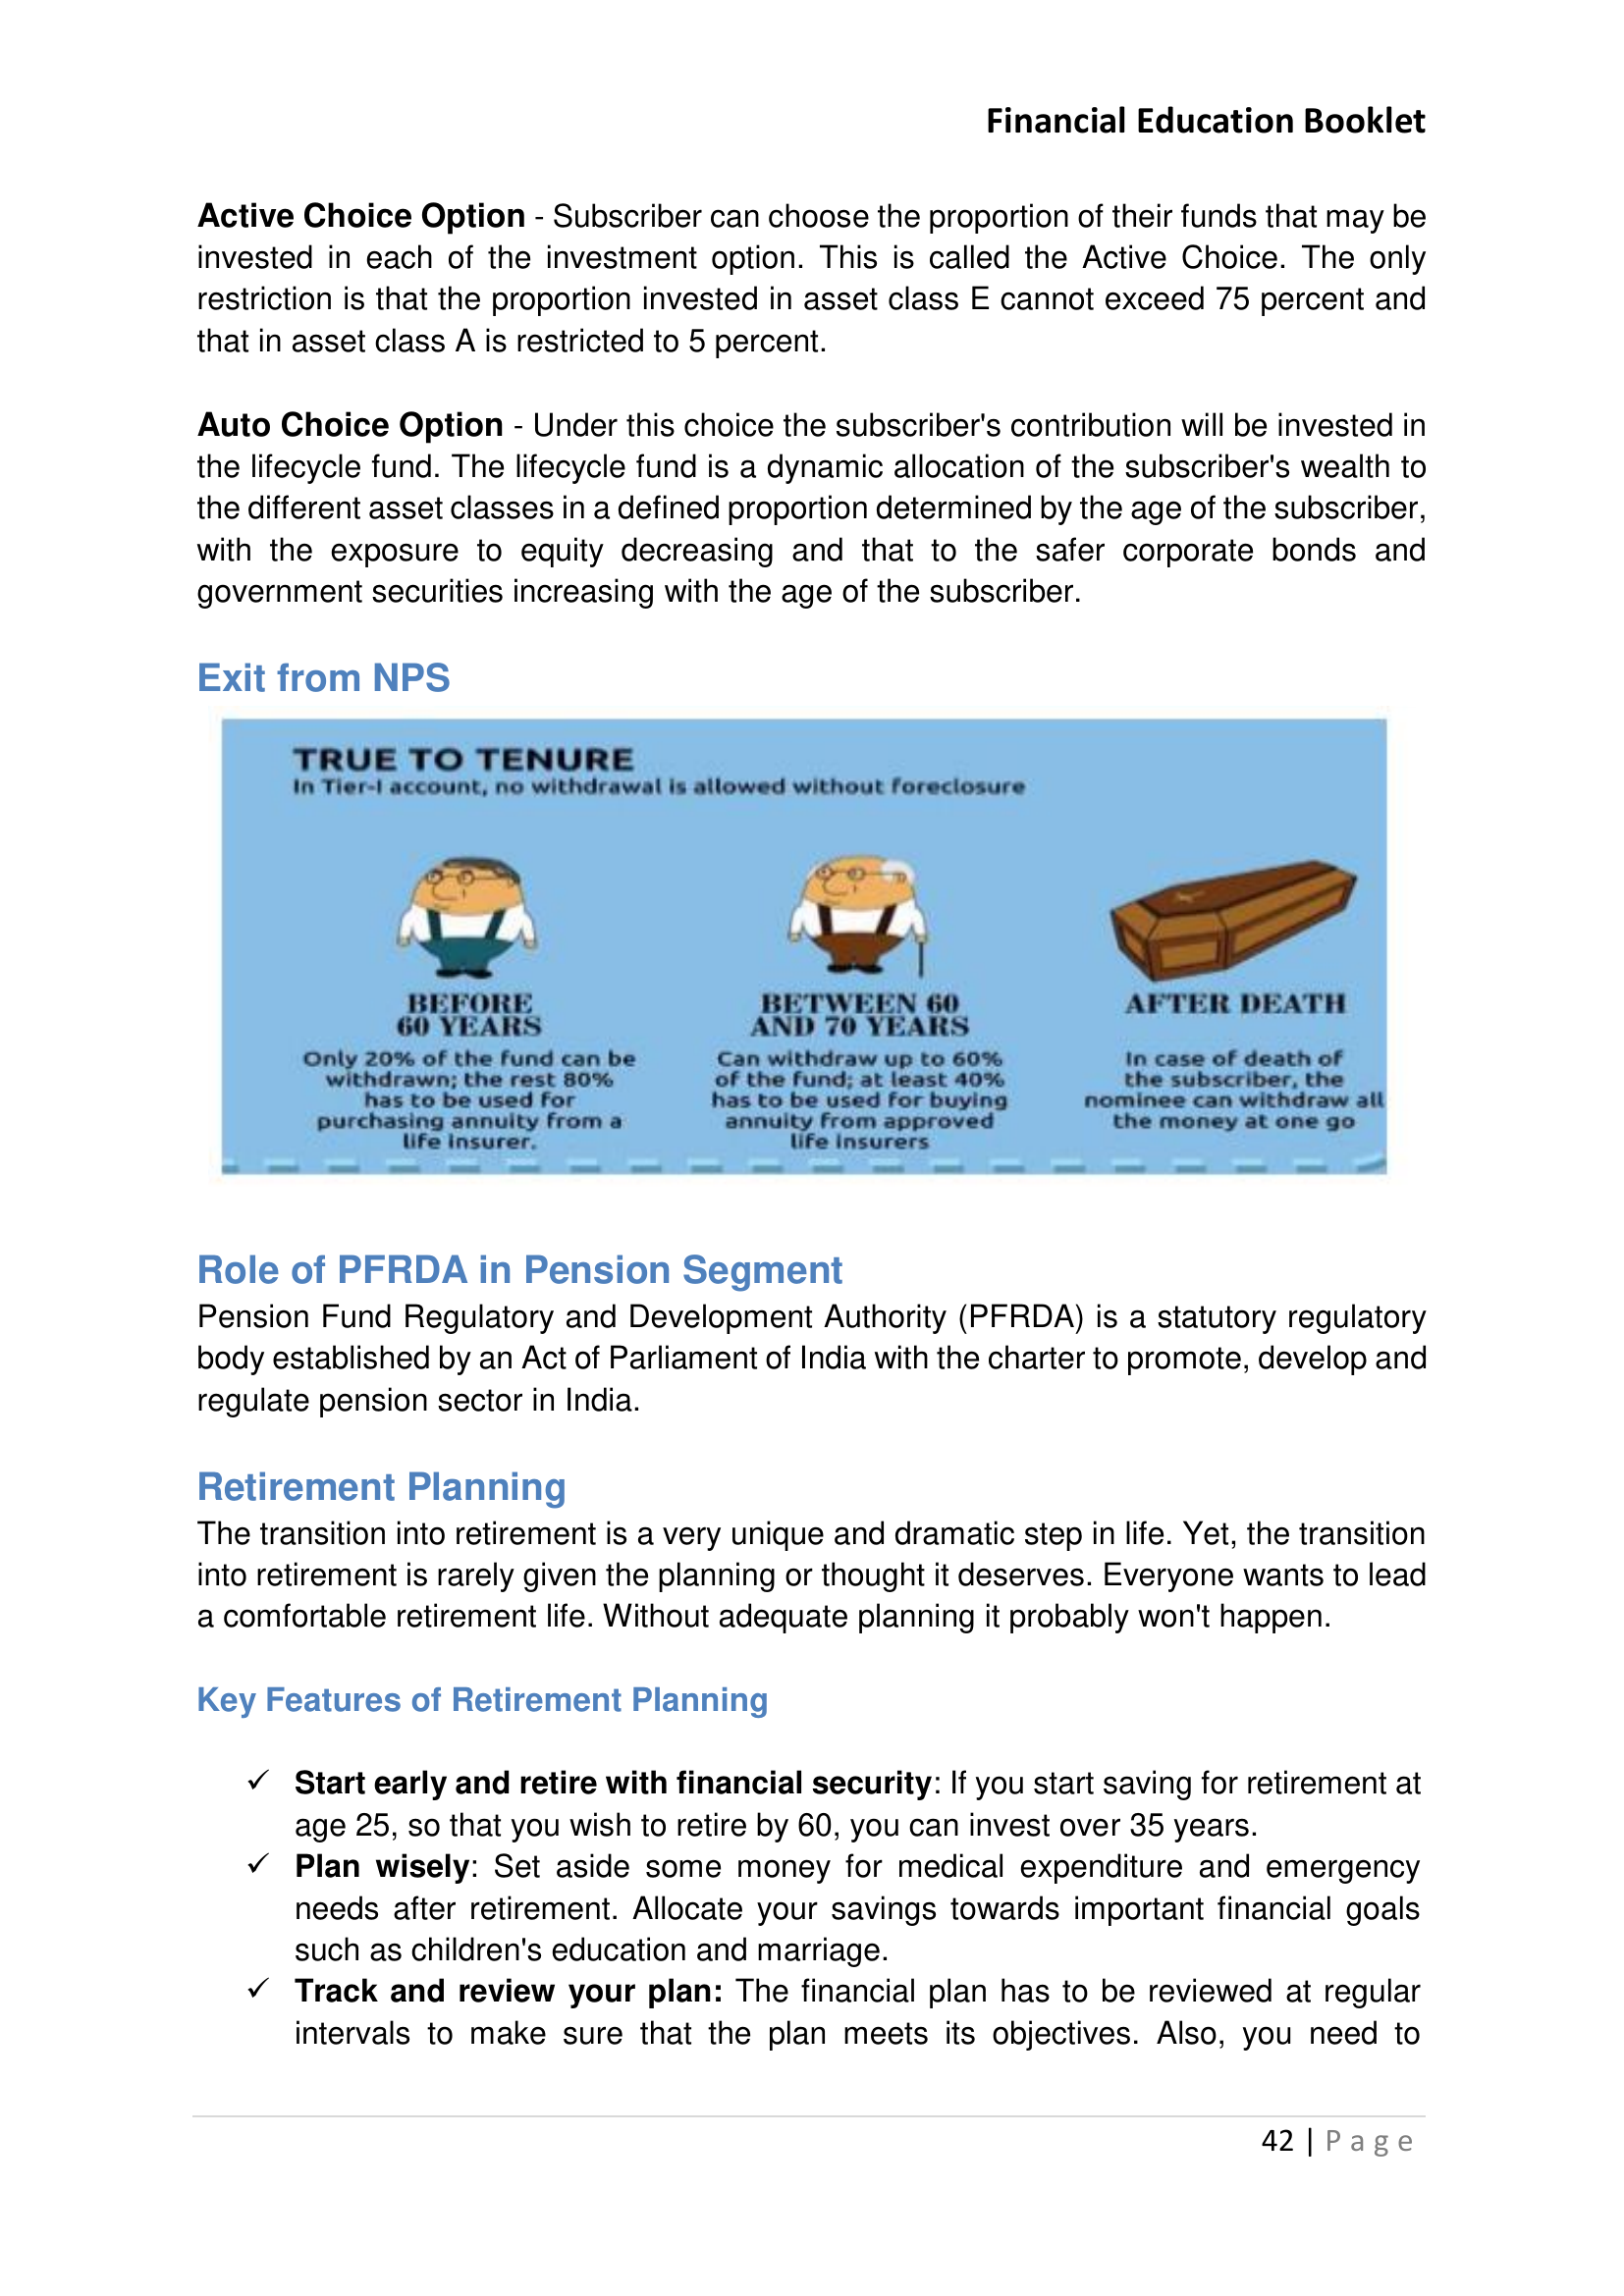

In [53]:
images[41]

as we can see the page with the embedded image with the relevant information is retrieved. now let's pass the images to the VLM, gpt-4o-mini.

### Answer Generation

Using GPT-4o-mini, which is a multimodal Model by OpenaAI, and supports images as input. We can also use Open-source VLMs for this if we want more data privacy

In [61]:
client = OpenAI(api_key="YOUR_API_KEY")

def get_image(page_num):
    return images[page_num-1]

def convert_image_to_base64(image):
    img_byte_arr = io.BytesIO()
    image.save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()
    img_byte_arr = base64.b64encode(img_byte_arr).decode('utf-8')
    return img_byte_arr

In [62]:
def create_prompt(results):
    prompt = []
    
    for image in results:
        page = image['page_num']
        prompt.append(
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/png;base64,{convert_image_to_base64(get_image(page))}"
                }
            }
        )
    return prompt

def get_answer_from_images(query, retrieval_results):
    prompt = create_prompt(retrieval_results)
    response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {'role': 'system', 'content': 'The following images are a part of the document. The user will ask a question based on the images. If the answer to the question is present in the images provided, You will need to answer that. If the answer is not present in the image, you MUST say "I do not have enough information to answer the question".'},
        {
            "role": "user",
            "content": prompt,
        },
        {
            "role": "user",
            "content": query
        }
    ],
        max_tokens=300,
        top_p=0.1
    )
    return response.choices[0].message.content


In [64]:
answer = get_answer_from_images(query, results)
print('Answer:', answer)

Answer: The exit rules for the National Pension System (NPS) are as follows:

1. **Before 60 Years**: Only 20% of the fund can be withdrawn; the remaining 80% must be used to purchase an annuity from a life insurer.

2. **Between 60 and 70 Years**: Subscribers can withdraw up to 60% of the fund; at least 40% must be used to buy an annuity from approved life insurers.

3. **After Death**: In the event of the subscriber's death, the nominee can withdraw all the money at once.

These rules ensure that a portion of the funds is preserved for retirement income through annuities.


The answer generated through the gpt-4o-mini is correct based on the document. You can try more queries on the same document. Or you can just replace the pdf with a file of your choice.

### Combining retrieval and Answer Generation

In [59]:
def RAG(query, index = index, documents_to_retrieve = 4):
    results = index.search(query, k=documents_to_retrieve)
    print('Search Results:',results)
    return get_answer_from_images(query, results)

In [65]:
response = RAG(query)
print('Answer:',response)

Search Results: [{'doc_id': 1, 'page_num': 42, 'score': 17.625, 'metadata': {}, 'base64': None}, {'doc_id': 1, 'page_num': 41, 'score': 16.25, 'metadata': {}, 'base64': None}, {'doc_id': 1, 'page_num': 53, 'score': 15.1875, 'metadata': {}, 'base64': None}, {'doc_id': 1, 'page_num': 29, 'score': 13.9375, 'metadata': {}, 'base64': None}]
Answer: The exit rules for the National Pension System (NPS) are as follows:

1. **Before 60 Years**: Only 20% of the fund can be withdrawn; the remaining 80% must be used to purchase an annuity from a life insurer.

2. **Between 60 and 70 Years**: Subscribers can withdraw up to 60% of the fund; at least 40% must be used to buy an annuity from approved life insurers.

3. **After Death**: In the event of the subscriber's death, the nominee can withdraw all the money at once.

These rules ensure that a portion of the funds is preserved for retirement income through annuities.
